In [15]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from wordcloud import WordCloud
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [16]:
#load datset
fname = 'data2.txt'
articles = []
errs = 0
with open(fname, 'r') as f:
    art = []
    while True:
        line = f.readline()
        if not line:
            break
        if 'URL' in line:
            if art != []:
                paper = ' '.join(art)
                if 'No corrections appeared in print' not in paper: #error papers
                    articles.append(paper)
                else:
                    errs += 1
            art = []
        elif line not in {'\n', ' '}:
            art.append(line.rstrip('\n'))

In [17]:
print(len(articles), errs)

98 0


In [18]:
class Vocab(TfidfVectorizer):
    def __init__(self, texts, **kwargs):
        super(Vocab, self).__init__(**kwargs)
        self.fit(texts)

    def __len__(self):
        return len(self.vocabulary_)
    
    def _to_bow(self, sent):
        prep = self.build_preprocessor()
        analyzer = self.build_analyzer()
        seq = analyzer(prep(sent))
        return [w for w in seq if w in self.vocabulary_]
        

    def _to_indices(self, sent):
        return [self.vocabulary_[w] for w in self._to_bow(sent)]


def save_model(model, filename):
    print('saving model to %s ...' % filename)
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    print('loading model from %s ...' % filename)
    return pickle.load(open(filename, 'rb'))

In [19]:
nlp = spacy.load('en_core_web_sm')
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    def __call__(self, doc):
        return [t.lemma_ for t in self.wnl(doc)]

In [20]:
vocab_size = 15000

kwargs = {'stop_words': 'english', 'max_df': 0.5, 'min_df': 3, 'ngram_range': (1, 1),
            'max_features': vocab_size, 'strip_accents': 'unicode'}
try:
    vocab = load_model('vocab.mode')
except:
    print('... creating new model')
    vocab = Vocab(articles, tokenizer=LemmaTokenizer(), **kwargs)

loading model from vocab.mode ...
... creating new model


/home/gayathri/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-PRON-', 'make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [21]:
print(len(vocab))
save_model(vocab, 'model/vocab.mod')

375
saving model to model/vocab.mod ...


In [22]:
text = 'Earlier, the state human right commission said it had evidence that 2,156 bodies had been buried in 40 graves over the last 20 years.The commission is the first government body to confirm what others have previously alleged.'
print(vocab._to_bow(text))

['earlier', 'previously']


In [23]:
import pyLDAvis
pyLDAvis.enable_notebook()
import gensim

In [24]:
arts_in_bow = [vocab._to_bow(art) for art in articles]
dct = gensim.corpora.Dictionary(arts_in_bow)
corpus = [dct.doc2bow(a) for a in arts_in_bow]

In [25]:
len(dct.keys())

375

In [26]:
num_topics = 20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dct, passes=5, 
                                           alpha=[0.01]*num_topics, eta=[0.01]*len(dct.keys()))
if not os.path.exists('model'):
    os.makedirs('model')
ldamodel.save('model/lda.gensim')
topics = ldamodel.print_topics(num_words=30)
for topic in topics:
    print(topic)

(0, '0.016*"forest" + 0.014*"—" + 0.010*"\'s" + 0.009*"chronicle" + 0.009*"gerwig" + 0.009*"florence" + 0.009*"louisa" + 0.009*"little" + 0.009*"hunt" + 0.009*"ability" + 0.009*"bleak" + 0.009*"long" + 0.009*"feyre" + 0.009*"live" + 0.009*"place" + 0.009*"rest" + 0.009*"wolf" + 0.009*"pursue" + 0.009*"fight" + 0.009*"flesh" + 0.009*"kill" + 0.009*"survival" + 0.009*"cold" + 0.009*"winter" + 0.009*"resist" + 0.009*"month" + 0.009*"spot" + 0.009*"–" + 0.009*"deer" + 0.009*"adaptation"')
(1, '0.106*"harry" + 0.087*"potter" + 0.035*"\'s" + 0.031*"goblet" + 0.027*"radcliffe" + 0.025*"grint" + 0.024*"rupert" + 0.024*"emma" + 0.024*"hermione" + 0.024*"ron" + 0.024*"daniel" + 0.023*"weasley" + 0.023*"watson" + 0.023*"sequel" + 0.023*"follow" + 0.022*"david" + 0.022*"year" + 0.021*"write" + 0.020*"steve" + 0.020*"azkaban" + 0.020*"heyman" + 0.020*"kloves" + 0.020*"story" + 0.019*"prisoner" + 0.019*"instalment" + 0.018*"star" + 0.017*"rowling" + 0.016*"grang" + 0.016*"j." + 0.016*"2004"')
(2, '0

In [27]:
print(ldamodel)

LdaModel(num_terms=375, num_topics=20, decay=0.5, chunksize=2000)


In [28]:
ldamodel.get_document_topics(dct.doc2bow(vocab._to_bow(articles[1])))

[(4, 0.9966192)]

In [29]:
ldamodel.num_terms

375

In [16]:
def get_topics(lda, num_words=30):
    l_topics = []
    for i in range(lda.num_topics):
        topic = ldamodel.state.get_lambda()[i]
        topic = topic / np.sum(topic)
        mx_indices = sorted(range(lda.num_terms), key=lambda a: topic[a], reverse=True)[:num_words]
        words = [lda.id2word[j] for j in mx_indices]
        l_topics.append(words)
    return l_topics

In [17]:
print(get_topics(ldamodel))

[['forest', "'s", 'jackson', 'ability', 'deer', 'fight', 'rest', 'month', 'place', 'flesh', 'cold', 'character', '–', 'pursue', 'long', 'percy', 'spot', 'kill', 'bleak', 'survival', 'live', 'hunt', 'feyre', 'winter', 'series', 'resist', 'wolf', 'narrator', 'riordan', 'appear'], ['jackson', 'series', 'percy', "'s", 'character', 'riordan', 'narrator', 'appear', 'hero', '"', 'greek', 'protagonist', 'rick', 'main', 'camp', 'greco', 'story', 'magician', 'demigod', 'chronicle', '&', 'blood', 'collection', 'ongoing', 'crossover', 'egyptian', 'heroes', 'title', 'apollo', 'make'], ['(', ')', '3d', 'journey', '2008', 'earth', 'center', 'new', 'produce', 'adventure', 'line', 'star', 'cinema', 'adaptation', '1959', 'theater', 'fantasy', 'american', 'warner', 'ring', 'sean', 'promote', '11', 'july', 'multiple', 'release', 'briem', 'verne', 'picture', 'notably'], ['jackson', "'s", 'character', 'percy', 'series', 'appear', 'riordan', 'narrator', 'rick', 'protagonist', '"', 'hero', 'greek', 'serve', '

In [18]:
probs = ldamodel.state.get_lambda()
probs = probs / np.sum(probs, axis=1, keepdims=True)

In [19]:
np.sum(probs[0])

1.0000001

In [20]:
from wordcloud import WordCloud

In [21]:
def vis_topic(topic, save_fname=None, **kwargs):
    wordcloud = WordCloud(**kwargs).generate(' '.join(topic))
    if save_fname is not None:
        wordcloud.to_file(save_fname)
    return wordcloud
num_topics = ldamodel.num_topics
w = h = 200
import cv2 as cv
mask = cv.imread('img/circle.jpg')
wcargs = {'width': w, 'height': h, 'background_color': "rgba(255, 255, 255, 0)", 'mode': "RGBA",
        'max_font_size': 100, 'min_font_size': 10, 'colormap': 'Paired', 'mask': mask}

In [22]:
topics = get_topics(ldamodel)
print(topics[1])

['jackson', 'series', 'percy', "'s", 'character', 'riordan', 'narrator', 'appear', 'hero', '"', 'greek', 'protagonist', 'rick', 'main', 'camp', 'greco', 'story', 'magician', 'demigod', 'chronicle', '&', 'blood', 'collection', 'ongoing', 'crossover', 'egyptian', 'heroes', 'title', 'apollo', 'make']


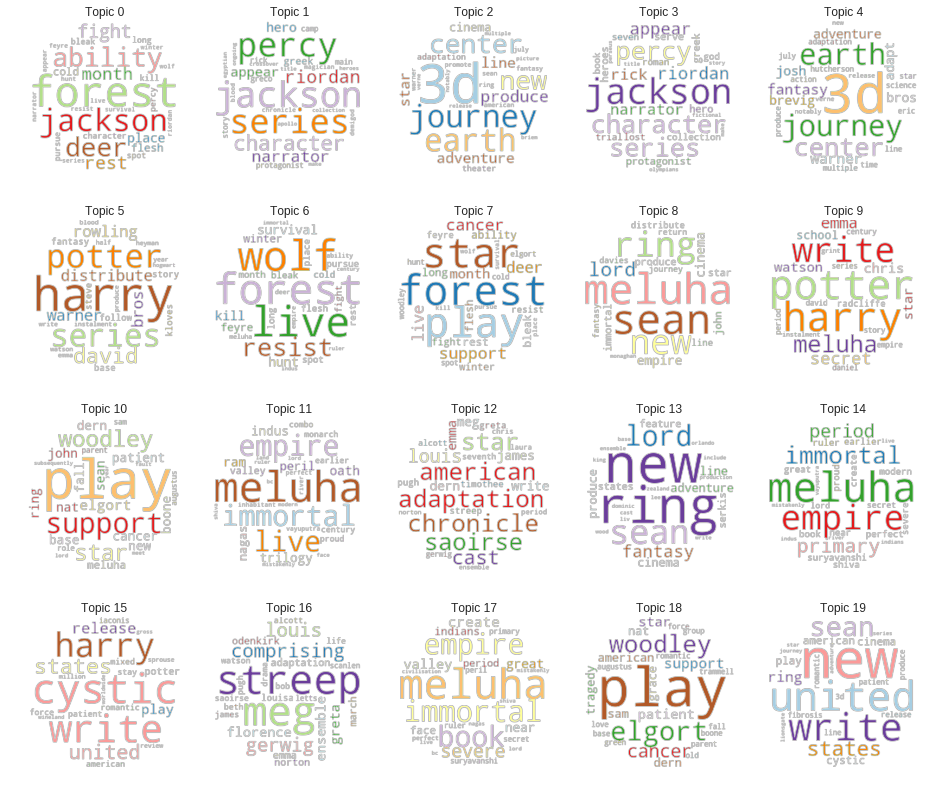

In [23]:
fig, axes = plt.subplots(num_topics // 5, 5, figsize=(16, 14))
for i in range(num_topics):
    r, c = i // 5, i % 5
    
    wordcloud = vis_topic(topics[i], **wcargs)
    axes[r, c].imshow(wordcloud, interpolation="bilinear")
    axes[r, c].axis("off")
    axes[r, c].set_title('Topic %d' % i)

wordcloud.to_file('wordcloud.png')
plt.show()